In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr
from xgcm import Grid
import numpy as np
import pandas as pd
from scipy import signal

import IPython.display
import cmocean as cm
import sys, os, glob
import warnings
warnings.simplefilter("ignore") 

from IPython.display import Image

from dask.distributed import Client

In [2]:
# Load workers:
client = Client(n_workers=8)
client

<Client: 'tcp://127.0.0.1:41041' processes=8 threads=8, memory=22.46 GiB>

## Load datasets

In [3]:
base = '/g/data/e14/rmh561/croco/'
base_data = base + 'archive/'
base_analysis = base + '/analysis/'

os.chdir(base_analysis + 'PAC12_75_cpl')

In [63]:
# define runs:
expdict = {'CROCO-WRF Spinup':{'exp':'PAC12_75_cpl','expn':'exp01','CPL':True}
        ,'CROCO-WRF Smooth-SST':{'exp':'PAC12_75_cpl','expn':'exp03','CPL':True}
         ,'CROCO Control':{'exp':'PAC12_75','expn':'exp11','CPL':False}
          }
cont = 'CROCO-WRF Spinup'

In [64]:
# Load CROCO data:
data_typs = ['mon','3day','day','ts_3day']
year = '2014' # leave blank for all available

data = {}
for nam in expdict.keys():
    print(nam)
    exp = expdict[nam]['exp']
    expn = expdict[nam]['expn']
    data[nam] = {}
    for typ in data_typs:
        data[nam][typ] = xr.open_mfdataset(sorted(glob.glob(base_data + exp + '/' + exp + '_' + expn + '/' + year + '*/croco_out_' + typ + '.nc')), concat_dim="time_counter", combine="nested",data_vars='minimal', coords='minimal', compat='override',parallel=True,chunks={'time_counter':1}).rename({'time_counter':'time'})
gfiles = glob.glob(base_data + exp + '/' + exp + '_' + expn + '/' + year + '*/croco_out_grd.nc')
grd = xr.open_dataset(gfiles[0],chunks={'y_rho':100,'x_rho':100})

CROCO-WRF Spinup
CROCO-WRF Smooth-SST
CROCO Control


In [65]:
# Deal with CROCO coordinates:
for nam in expdict.keys():
    print(nam)
    for d in data[nam].values():
        try:
            d["x_rho"] = d.nav_lon_rho.isel(y_rho=0)
            d["y_rho"] = d.nav_lat_rho.isel(x_rho=0)
            d["x_w"] = d.nav_lon_rho.isel(y_rho=0).rename({'x_rho':'x_w'})
            d["y_w"] = d.nav_lat_rho.isel(x_rho=0).rename({'y_rho':'y_w'})
            d["x_u"] = d.nav_lon_u.isel(y_u=0)
            d["y_u"] = d.nav_lat_u.isel(x_u=0)
            d["x_v"] = d.nav_lon_v.isel(y_v=0)
            d["y_v"] = d.nav_lat_v.isel(x_v=0)
            d = d.set_coords({'x_rho','y_rho','x_u','y_u','x_v','y_v','x_w','y_w'})
        except:
            d["x_rho"] = d.nav_lon.isel(y=0)
            d["y_rho"] = d.nav_lat.isel(x=0)
            d = d.set_coords({'x_rho','y_rho'})

        try:
            d["z_rho"] = d.z_rho.mean('time').fillna(0.)
            d = d.set_coords({'z_rho'})
        except:
            pass

# Generate xgcm grid object:
grid = Grid(data[nam]['mon'],coords={"x":{"center":"x_rho","inner":"x_u"},
                         "y":{"center":"y_rho","inner":"y_v"},
                         "s":{"center":"s_rho","outer":"s_w"}},periodic=False)

CROCO-WRF Spinup
CROCO-WRF Smooth-SST
CROCO Control


In [79]:
# Load WRF data:
data_typs = {'day':'3d_1D','hr':'3d_1H','mon':'out'}
year = '2014'

for nam in expdict.keys():
    if expdict[nam]['CPL']:
        print(nam)
        exp = expdict[nam]['exp']
        expn = expdict[nam]['expn']
        for typ in data_typs.keys():
            data[nam]['wrf_' + typ] = xr.open_mfdataset(sorted(glob.glob(base_data + exp + '/' + exp + '_' + expn + '/' + year + '*/wrf' + data_typs[typ] + '*.nc')), concat_dim="time_counter", combine="nested",data_vars='minimal', coords='minimal', compat='override',parallel=True,chunks={'time_counter':1}).rename({'time_counter':'time'})

        lon = data[nam]['wrf_day'].nav_lon.isel(y=0)
        lon = np.where(np.less(lon,0.).values,lon+360.,lon)
        lat = data[nam]['wrf_day'].nav_lat.isel(x=0).values
        for typ in data_typs:
            data[nam]['wrf_' + typ]["x"] = lon
            data[nam]['wrf_' + typ]["y"] = lat

CROCO-WRF Spinup
CROCO-WRF Smooth-SST


In [28]:
# Set limit parameters for observations:
minyr  = data[nam]['mon'].time.min('time').values.astype('datetime64[Y]').astype(int)+1970
maxyr  = data[nam]['mon'].time.max('time').values.astype('datetime64[Y]').astype(int)+1970
minlon = data[nam]['mon'].x_rho.min('x_rho').values
maxlon = data[nam]['mon'].x_rho.max('x_rho').values
minlat = data[nam]['mon'].y_rho.min('y_rho').values
maxlat = data[nam]['mon'].y_rho.max('y_rho').values

In [17]:
# Observational SST:
files = []
for yr in np.arange(minyr,maxyr+1,1):
    files += glob.glob('/g/data/ua8/NOAA_OISST/AVHRR/v2-1_modified/*_' + str(yr) + '.nc')
OISST = xr.open_mfdataset(files,concat_dim="time", combine="nested",
                  data_vars='minimal', coords='minimal', compat='override',parallel=True).isel(zlev=0)

#OISST = OISST.sel(lon=slice(minlon,maxlon)).sel(lat=slice(minlat,maxlat))
OISST = OISST.rename({'lon':'x_rho','lat':'y_rho'})

In [18]:
# Observational SSH:
files = []
for yr in np.arange(minyr,maxyr+1,1):
    files += glob.glob('/g/data/ua8/CMEMS_SeaLevel/v2019/' + str(yr) + '/*.nc')
CMEMS = xr.open_mfdataset(files,concat_dim="time", combine="nested",
                  data_vars='minimal', coords='minimal', compat='override',parallel=True)

CMEMS = CMEMS.sel(longitude=slice(minlon,maxlon)).sel(latitude=slice(minlat,maxlat))
CMEMS = CMEMS.rename({'longitude':'x_rho','latitude':'y_rho'})

In [19]:
# SODA reanalysis:
files = []
for yr in np.arange(minyr,maxyr+1,1):
    files += glob.glob('/g/data/e14/rmh561/croco/data/DATA/SODA342_PAC12_75/soda3.4.2_5dy_ocean_reg_' + str(yr) + '_*.nc')
SODA = xr.open_mfdataset(files,concat_dim="time", combine="nested",
                  data_vars='minimal', coords='minimal', compat='override',parallel=True)

SODA = SODA.sel(xt_ocean=slice(minlon,maxlon)).sel(yt_ocean=slice(minlat,maxlat)).sel(xu_ocean=slice(minlon,maxlon)).sel(yu_ocean=slice(minlat,maxlat))
SODA = SODA.rename({'xt_ocean':'x_rho','yt_ocean':'y_rho'})

In [40]:
# ACCESS-OM2 data:
import cosima_cookbook as cc
session = cc.database.create_session()
from collections import OrderedDict
exptdict = OrderedDict([
    ('1degIAF',   {'model':'ACCESS-OM2 IAF', 'expt':'1deg_jra55_iaf_omip2_cycle6', 'itime':pd.datetime(minyr,1,1), 'ftime':pd.datetime(maxyr,12,31)}),
    ('025degIAF', {'model':'ACCESS-OM2-025 IAF', 'expt':'025deg_jra55_iaf_omip2_cycle6', 'itime':pd.datetime(minyr,1,1), 'ftime':pd.datetime(maxyr,12,31)}),
    ('01degIAF', {'model':'ACCESS-OM2-01 IAF', 'expt':'01deg_jra55v140_iaf_cycle3', 'itime':pd.datetime(minyr,1,1), 'ftime':pd.datetime(maxyr,12,31)}),
])

# Snapshots for checking WRF/CROCO compatiblity:

Text(0.5, 1.0, 'CROCO-WRF Smooth-SST CROCO SST 2014-02-12')

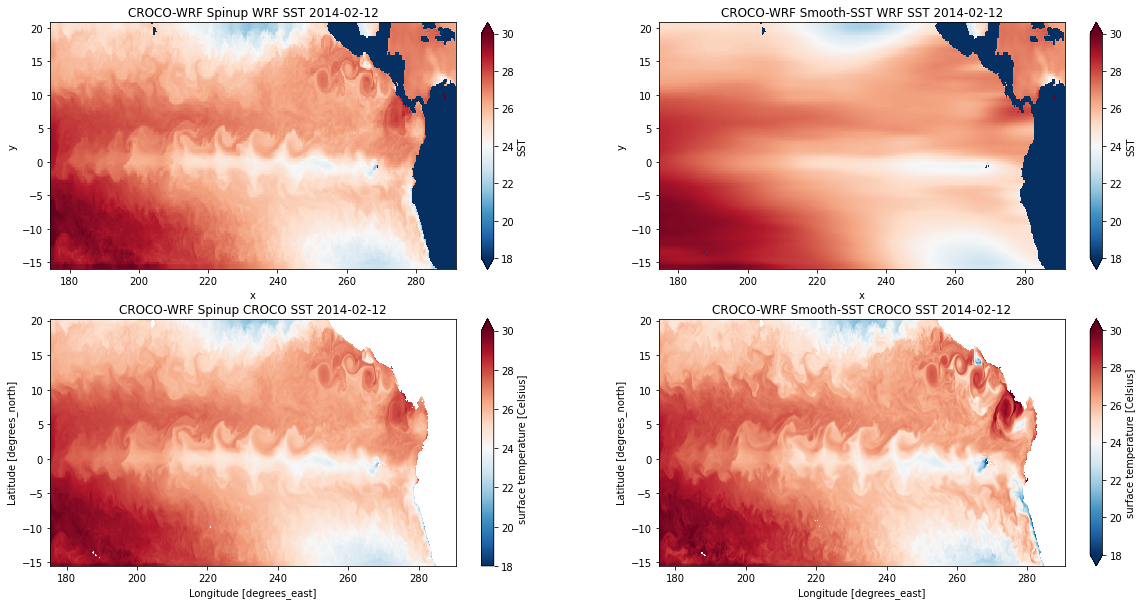

In [85]:
#Calculations:
time = '2014-02-12'

fig,axes = plt.subplots(nrows=2,ncols=2,figsize=(20,10))
(data['CROCO-WRF Spinup']['wrf_day'].SST-273.15).sel(time=time).plot(ax=axes[0][0],cmap='RdBu_r',vmin=18.,vmax=30.)
axes[0][0].set_title('CROCO-WRF Spinup WRF SST ' + time)
(data['CROCO-WRF Smooth-SST']['wrf_day'].SST-273.15).sel(time=time).plot(ax=axes[0][1],cmap='RdBu_r',vmin=18.,vmax=30.)
axes[0][1].set_title('CROCO-WRF Smooth-SST WRF SST ' + time)
data['CROCO-WRF Spinup']['day'].temp_surf.sel(time=time).plot(ax=axes[1][0],cmap='RdBu_r',vmin=18.,vmax=30.)
axes[1][0].set_title('CROCO-WRF Spinup CROCO SST ' + time)
data['CROCO-WRF Smooth-SST']['day'].temp_surf.sel(time=time).plot(ax=axes[1][1],cmap='RdBu_r',vmin=18.,vmax=30.)
axes[1][1].set_title('CROCO-WRF Smooth-SST CROCO SST ' + time)


Text(0.5, 1.0, 'CROCO-WRF Smooth-SST CROCO V 2014-02-12')

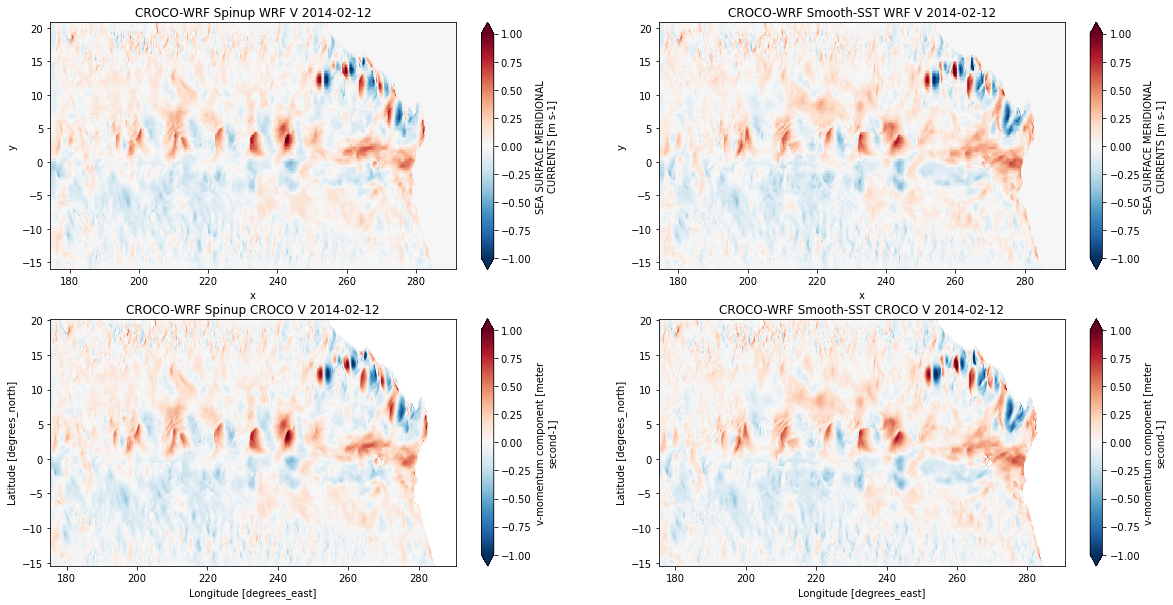

In [87]:
#Calculations:
time = '2014-02-12'

fig,axes = plt.subplots(nrows=2,ncols=2,figsize=(20,10))
data['CROCO-WRF Spinup']['wrf_day'].VOCE.sel(time=time).plot(ax=axes[0][0],cmap='RdBu_r',vmin=-1.,vmax=1.)
axes[0][0].set_title('CROCO-WRF Spinup WRF V ' + time)
data['CROCO-WRF Smooth-SST']['wrf_day'].VOCE.sel(time=time).plot(ax=axes[0][1],cmap='RdBu_r',vmin=-1.,vmax=1.)
axes[0][1].set_title('CROCO-WRF Smooth-SST WRF V ' + time)
data['CROCO-WRF Spinup']['day'].v_surf.sel(time=time).plot(ax=axes[1][0],cmap='RdBu_r',vmin=-1.,vmax=1.)
axes[1][0].set_title('CROCO-WRF Spinup CROCO V ' + time)
data['CROCO-WRF Smooth-SST']['day'].v_surf.sel(time=time).plot(ax=axes[1][1],cmap='RdBu_r',vmin=-1.,vmax=1.)
axes[1][1].set_title('CROCO-WRF Smooth-SST CROCO V ' + time)


Text(0.5, 1.0, 'CROCO-WRF Smooth-SST WRF SHFLX 2014-05-12')

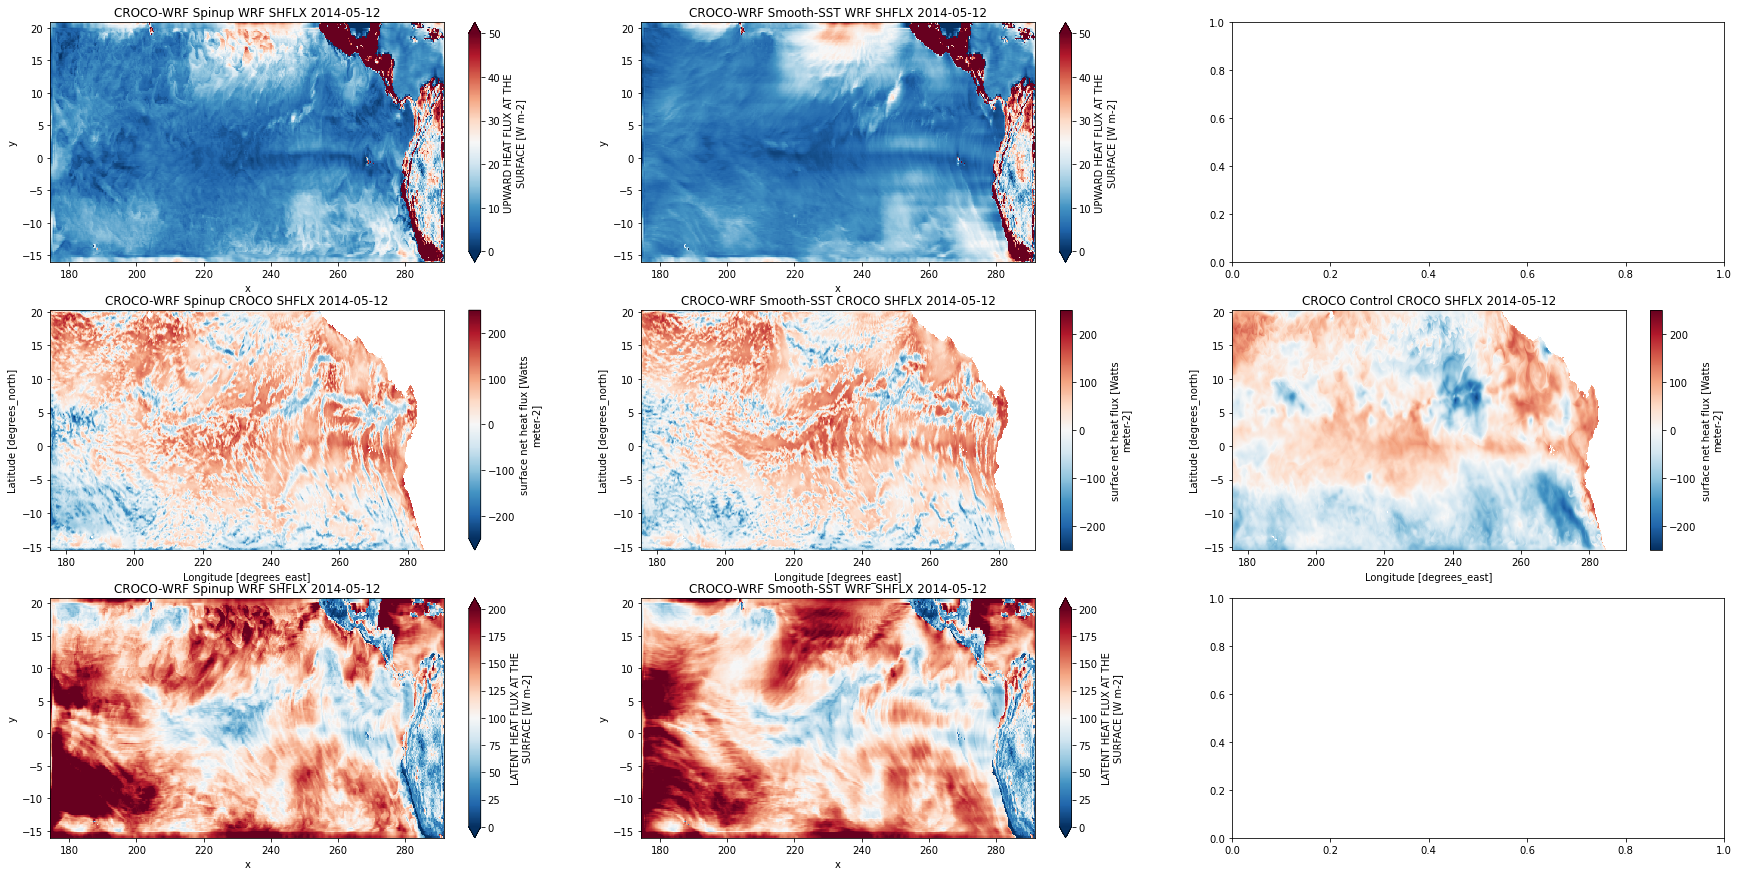

In [104]:
#Calculations:
time = '2014-05-12'

fig,axes = plt.subplots(nrows=3,ncols=3,figsize=(30,15))
SHFLX = data['CROCO-WRF Spinup']['wrf_day'].HFX
#         data['CROCO-WRF Spinup']['wrf_day'].LH+
#         data['CROCO-WRF Spinup']['wrf_day'].GLW+
#         data['CROCO-WRF Spinup']['wrf_day'].GSW
SHFLX.sel(time=time).plot(ax=axes[0][0],cmap='RdBu_r',vmin=0.,vmax=50.)
axes[0][0].set_title('CROCO-WRF Spinup WRF SHFLX ' + time)
SHFLX = data['CROCO-WRF Smooth-SST']['wrf_day'].HFX
#         data['CROCO-WRF Smooth-SST']['wrf_day'].LH+
#         data['CROCO-WRF Smooth-SST']['wrf_day'].GLW+
#         data['CROCO-WRF Smooth-SST']['wrf_day'].GSW
SHFLX.sel(time=time).plot(ax=axes[0][1],cmap='RdBu_r',vmin=0.,vmax=50.)
axes[0][1].set_title('CROCO-WRF Smooth-SST WRF SHFLX ' + time)

data['CROCO-WRF Spinup']['day'].shflx.sel(time=time).plot(ax=axes[1][0],cmap='RdBu_r',vmin=-250.,vmax=250.)
axes[1][0].set_title('CROCO-WRF Spinup CROCO SHFLX ' + time)
data['CROCO-WRF Smooth-SST']['day'].shflx.sel(time=time).plot(ax=axes[1][1],cmap='RdBu_r',vmin=-250.,vmax=250.)
axes[1][1].set_title('CROCO-WRF Smooth-SST CROCO SHFLX ' + time)
data['CROCO Control']['day'].shflx.sel(time=time).plot(ax=axes[1][2],cmap='RdBu_r',vmin=-250.,vmax=250.)
axes[1][2].set_title('CROCO Control CROCO SHFLX ' + time)

SHFLX = data['CROCO-WRF Spinup']['wrf_day'].LH
SHFLX.sel(time=time).plot(ax=axes[2][0],cmap='RdBu_r',vmin=0.,vmax=200.)
axes[2][0].set_title('CROCO-WRF Spinup WRF SHFLX ' + time)
SHFLX = data['CROCO-WRF Smooth-SST']['wrf_day'].LH
SHFLX.sel(time=time).plot(ax=axes[2][1],cmap='RdBu_r',vmin=0.,vmax=200.)
axes[2][1].set_title('CROCO-WRF Smooth-SST WRF SHFLX ' + time)

Text(0.5, 1.0, 'CROCO-WRF Smooth-SST WRF Latent HF 2014-05-06 - 2014-05-18')

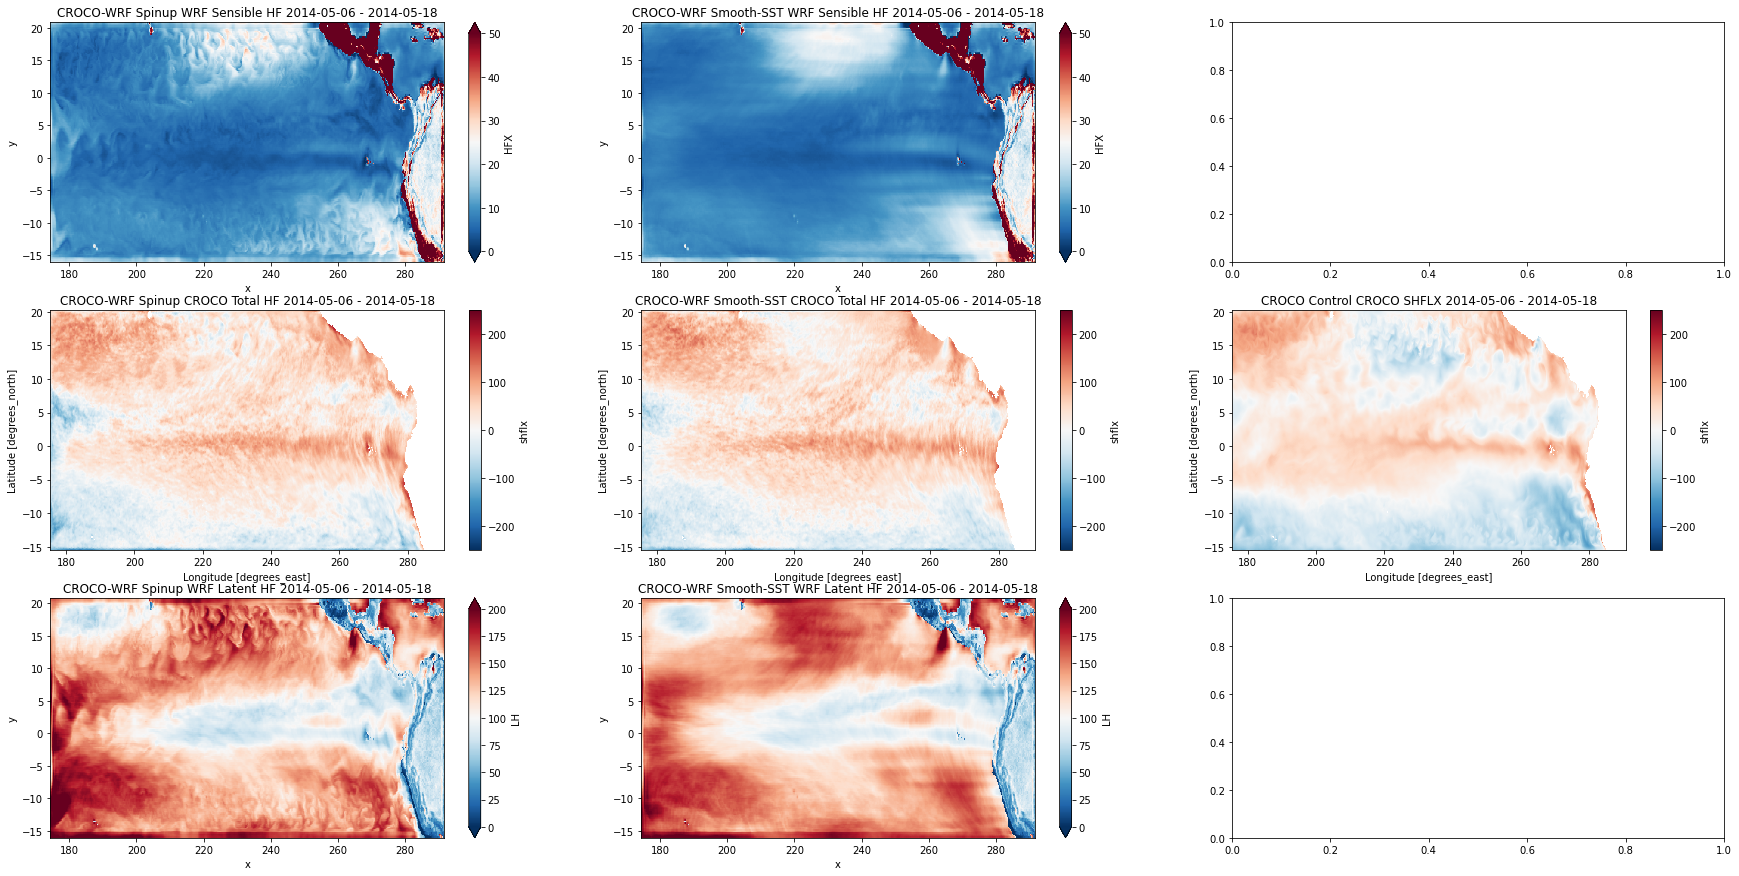

In [106]:
#Calculations:
times = ['2014-05-06','2014-05-18']

fig,axes = plt.subplots(nrows=3,ncols=3,figsize=(30,15))
SHFLX = data['CROCO-WRF Spinup']['wrf_day'].HFX
#         data['CROCO-WRF Spinup']['wrf_day'].LH+
#         data['CROCO-WRF Spinup']['wrf_day'].GLW+
#         data['CROCO-WRF Spinup']['wrf_day'].GSW
SHFLX.sel(time=slice(times[0],times[1])).mean('time').plot(ax=axes[0][0],cmap='RdBu_r',vmin=0.,vmax=50.)
axes[0][0].set_title('CROCO-WRF Spinup WRF Sensible HF ' + times[0] + ' - ' + times[1])
SHFLX = data['CROCO-WRF Smooth-SST']['wrf_day'].HFX
#         data['CROCO-WRF Smooth-SST']['wrf_day'].LH+
#         data['CROCO-WRF Smooth-SST']['wrf_day'].GLW+
#         data['CROCO-WRF Smooth-SST']['wrf_day'].GSW
SHFLX.sel(time=slice(times[0],times[1])).mean('time').plot(ax=axes[0][1],cmap='RdBu_r',vmin=0.,vmax=50.)
axes[0][1].set_title('CROCO-WRF Smooth-SST WRF Sensible HF ' + times[0] + ' - ' + times[1])

data['CROCO-WRF Spinup']['day'].shflx.sel(time=slice(times[0],times[1])).mean('time').plot(ax=axes[1][0],cmap='RdBu_r',vmin=-250.,vmax=250.)
axes[1][0].set_title('CROCO-WRF Spinup CROCO Total HF ' + times[0] + ' - ' + times[1])
data['CROCO-WRF Smooth-SST']['day'].shflx.sel(time=slice(times[0],times[1])).mean('time').plot(ax=axes[1][1],cmap='RdBu_r',vmin=-250.,vmax=250.)
axes[1][1].set_title('CROCO-WRF Smooth-SST CROCO Total HF ' + times[0] + ' - ' + times[1])

data['CROCO Control']['day'].shflx.sel(time=slice(times[0],times[1])).mean('time').plot(ax=axes[1][2],cmap='RdBu_r',vmin=-250.,vmax=250.)
axes[1][2].set_title('CROCO Control CROCO SHFLX ' + times[0] + ' - ' + times[1])

SHFLX = data['CROCO-WRF Spinup']['wrf_day'].LH
SHFLX.sel(time=slice(times[0],times[1])).mean('time').plot(ax=axes[2][0],cmap='RdBu_r',vmin=0.,vmax=200.)
axes[2][0].set_title('CROCO-WRF Spinup WRF Latent HF ' + times[0] + ' - ' + times[1])
SHFLX = data['CROCO-WRF Smooth-SST']['wrf_day'].LH
SHFLX.sel(time=slice(times[0],times[1])).mean('time').plot(ax=axes[2][1],cmap='RdBu_r',vmin=0.,vmax=200.)
axes[2][1].set_title('CROCO-WRF Smooth-SST WRF Latent HF ' + times[0] + ' - ' + times[1])

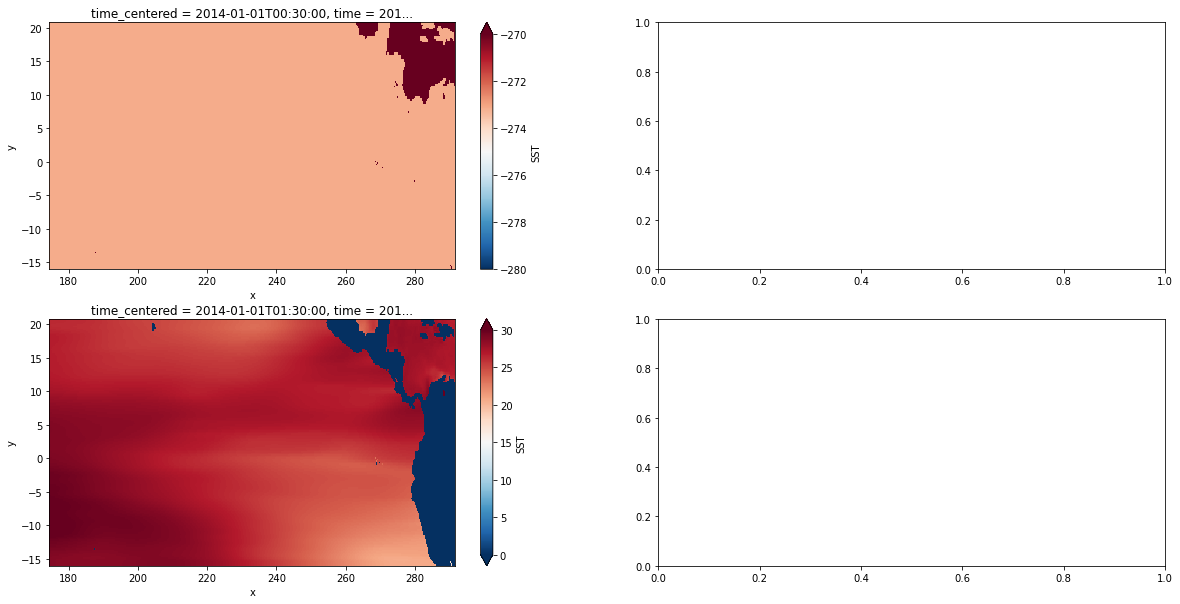

In [99]:
fig,axes = plt.subplots(nrows=2,ncols=2,figsize=(20,10))
(data['CROCO-WRF Smooth-SST']['wrf_hr'].SST-273.15).isel(time=0).plot(ax=axes[0][0],cmap='RdBu_r',vmin=-280.,vmax=-270.)
(data['CROCO-WRF Smooth-SST']['wrf_hr'].SST-273.15).isel(time=1).plot(ax=axes[1][0],cmap='RdBu_r',vmin=0.,vmax=30.)

## Domain Schematic:

In [53]:
from matplotlib.patches import Rectangle

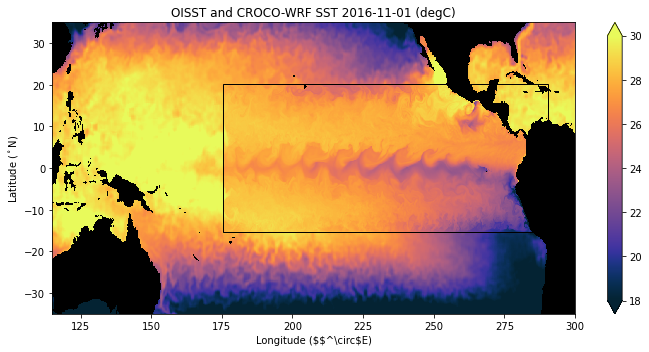

In [113]:
time = '2016-11-01'
plt.figure(figsize=(10,5))
xlims = [115.,300.]
ylims = [-35.,35.]
vlims = [18.,30.]

OISST.sst.sel(x_rho=slice(xlims[0],xlims[1])).sel(y_rho=slice(ylims[0],ylims[1])).sel(time=time).plot(cmap=cm.cm.thermal,vmin=vlims[0],vmax=vlims[1],cbar_kwargs={'label':''})

data['day'].temp_surf.sel(time=time).plot(cmap=cm.cm.thermal,vmin=vlims[0],vmax=vlims[1],add_colorbar=False)
#data['wrf_day'].WSPD10.sel(time=time).isel(time=0).plot.contour(levels=np.arange(0.,25.,2.),colors='k')
plt.gca().set_facecolor('k')
plt.gca().set_xlim(xlims)
plt.gca().set_ylim(ylims)
plt.gca().add_patch(Rectangle((minlon, minlat), maxlon-minlon, maxlat-minlat,
             edgecolor = 'black',
             fill=False,
             lw=1))
plt.title('OISST and CROCO-WRF SST ' + time + ' (degC)')
plt.xlabel('Longitude ($$^\circ$E)')
plt.ylabel('Latitude ($^\circ$N)')
plt.tight_layout()

plt.savefig('Domain_Fig.png',dpi=250)

# Some snapshots and TIW filtering (WRF data):

In [231]:
#Calculations:
time = '2014-11-15'

ln_hp_filt = 12.0
DX = (data['wrf_day'].nav_lon[0,1]-data['wrf_day'].nav_lon[0,0]).values

SST = (data['wrf_day'].SST-273.15).sel(time=time)
SST = SST.where(SST>-10.)
WSP = data['wrf_day'].WSPD10.sel(time=time)
LH = data['wrf_day'].LH.sel(time=time)

SST_TIW = (SST-SST.rolling(x=int(ln_hp_filt/DX),center=True).mean())
WSP_TIW = (WSP-WSP.rolling(x=int(ln_hp_filt/DX),center=True).mean())

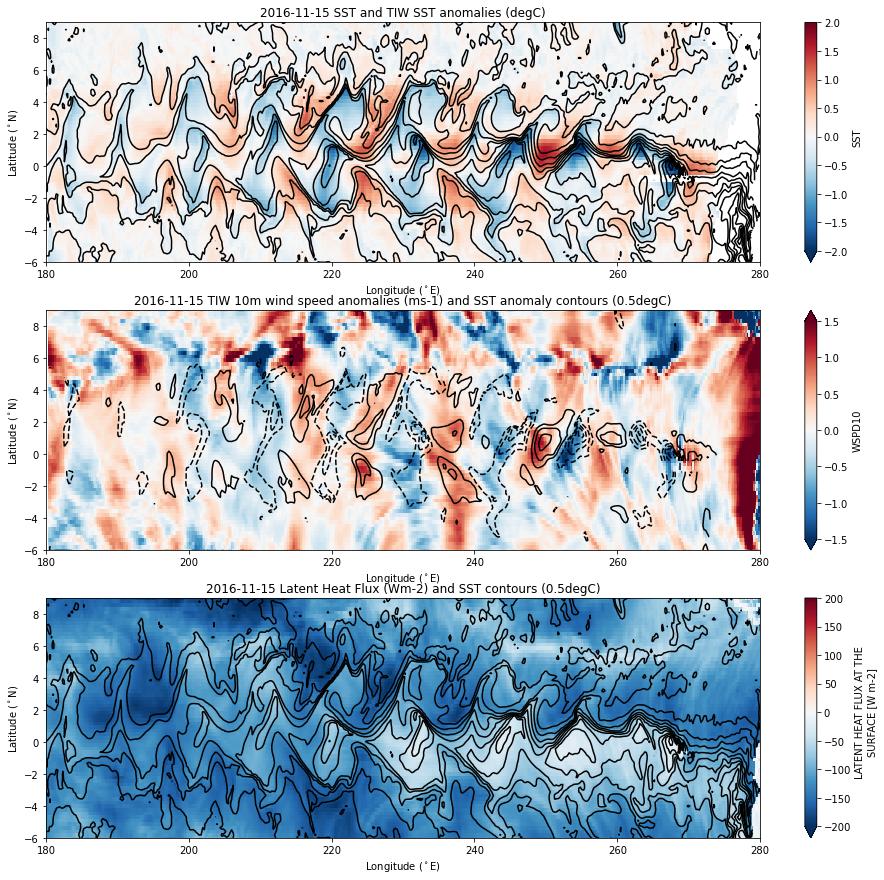

In [237]:
fig,axes = plt.subplots(nrows=3,ncols=1,figsize=(16,15))

SST.isel(time=0).plot.contour(levels=np.arange(0.,30.,0.5),colors='k',ax=axes[0])
SST_TIW.plot(ax=axes[0],vmin=-2.,vmax=2.,cmap='RdBu_r')
#WSP_TIW.isel(time=0).plot.contour(levels=np.arange(-3.0,0.,0.3),linestyle='dashed',colors='b',ax=axes)
#WSP_TIW.isel(time=0).plot.contour(levels=np.arange(0.3,3.3,0.3),colors='b',ax=axes)

WSP_TIW.plot(ax=axes[1],vmin=-1.5,vmax=1.5,cmap='RdBu_r')
SST_TIW.isel(time=0).plot.contour(levels=np.arange(-3.0,0.,0.5),linestyle='dashed',colors='k',ax=axes[1])
SST_TIW.isel(time=0).plot.contour(levels=np.arange(0.5,3.5,0.5),colors='k',ax=axes[1])

SST.isel(time=0).plot.contour(levels=np.arange(0.,30.,0.5),colors='k',ax=axes[2])
(-LH).plot(ax=axes[2],vmin=-200.,vmax=200.,cmap='RdBu_r')

for ax in axes:
    ax.set_xlim([180.,280.])
    ax.set_ylim([-6.,9.])
    ax.set_xlabel('Longitude ($^\circ$E)')
    ax.set_ylabel('Latitude ($^\circ$N)')
axes[0].set_title(time + ' SST and TIW SST anomalies (degC)')
axes[1].set_title(time + ' TIW 10m wind speed anomalies (ms-1) and SST anomaly contours (0.5degC)')
axes[2].set_title(time + ' Latent Heat Flux (Wm-2) and SST contours (0.5degC)')

plt.savefig('SST_WSP_LH.png',dpi=200)

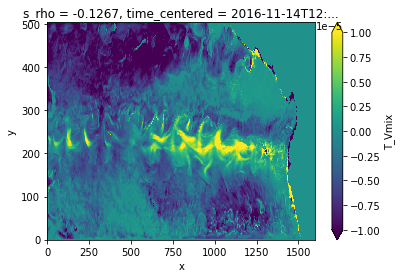

In [276]:
data['ts_3day'].T_Vmix.cumsum('s_rho').sel(time='2016-11-14').isel(s_rho=65).plot(vmin=-1.e-5,vmax=1.e-5)
#plt.gca().set_xlim([180.,280.])
#plt.gca().set_ylim([-6.,9.])